# Expt 1: Compute Jacobians 
And Save to disk for analysis

loaded checkpoint for INFERENCE


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(256 => 20, tanh)
│   summary(x) = 256-element Vector{Float64}
└ @ Flux /Users/arvindm/.julia/packages/Flux/n3cOc/src/layers/stateless.jl:60


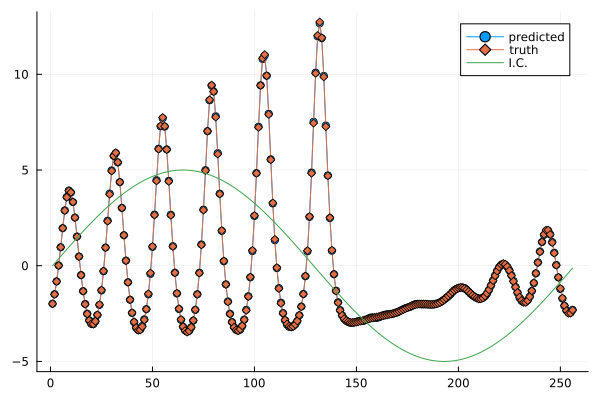

In [1]:
# Expt 1: gKdV

using DifferentialEquations,SciMLSensitivity,Zygote,LinearAlgebra,Plots
using SparseArrays, Random, Statistics, Optimisers, Flux, JLD2
using ForwardDiff

#------------------------------------------#
#        Simulation input parameters       #
#------------------------------------------#

begin 
    global N = 256                      # number of cells 
    global L = 5π                       # total length of 1d sim
    global dt = 0.01                     # time step
    global T = 1.0                       # total time 
    global nt = T / dt                   # number of timesteps
    global dx = L/N                      # spatial step
    global x = 0.0 : dx : (L-dx)         # discretized spatial dimension 
    global xgrid = collect(x)            # grid 
    global tsteps = 0.0:dt:T             # discretized time dimension 
    global tspan = (0,T)                 # end points of time integration for ODEProbem

    global ω0 = 0.5                      # Coriolis factor from geyer.quirchmayr_2018 paper
    global c  = 2.5                      # Soliton velocity 
    global A  = 5.0                      # Amplitude of wave in IC
    global xS = 1.5                      # Soliton shift from origin 
    global γ  = 1                        # Less-resolved-timesteps-for-training factor ; dt_train = γ dt_true 
    global ckpt_save_freq = 10
    global epochs = 10000
    global lr  = 0.01         
end 

include("../../src/numerical_derivatives.jl");

checkpoint_fpath = "./ckpt_expt1.jld2"

# derivative operators for train data
∂x1 = f1_secondOrder_central(N,dx)
∂x3 = f3_secondOrder_central(N,dx)

#ROM numerical scheme 
∂x3_rom = f3_secondOrder_central(N,dx)

function gKdV_ic_sinusoid(x,A,c,ω0)
    return -A*sin.(x./c .+ pi)
end
u0 = gKdV_ic_sinusoid(x,A,c,ω0) ;

# true gKdV pde
function true_gKdV(u,p,t)
    return (ω0 .* (∂x1 * u) - 3.0/2.0 .* u .* (∂x1 *u) - 1.0 ./ 6.0 .* (∂x3 * u)) .* p
end

# learnable parameter p , not used in training data generation, initialized with ones
# to make adjoint computation feasible
# save only initial condition and last timestep
pones = ones(N);
true_gKdV_prob = ODEProblem(true_gKdV, u0, tspan,pones)
#loss_true(u0, p) = sum(solve(true_gKdV_prob, Tsit5(), u0 = u0, p = p, saveat = dt));

## Create training data 
sol_true_gKdV = Array(solve(true_gKdV_prob,Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol = Float32(1e-6)));

model = Chain(
            Dense(N,20,tanh),
            Dense(20,20,tanh),
            Dense(20,20,tanh),
            Dense(20,N));

f = jldopen(checkpoint_fpath,"r")
p = f["p"];
close(f)
println("loaded checkpoint for INFERENCE")
_, re = Flux.destructure(model);
model = re(p); #load trained weights from checkpoint into model state.

function learned_gKdV(u,p,t)
    ϕ = re(p)
    u = ϕ(u) - 1.0 ./ 6.0 .* (∂x3_rom * u)
    return u
end 

learned_gKdV_prob = ODEProblem(learned_gKdV, u0, tspan, p)

function true_f(u)
    prob_true = ODEProblem(true_gKdV, u, tspan,pones)
    out = solve(prob_true,Tsit5(),save_everystep=false)[end]
end

function pred_f(u)
    prob_pred = ODEProblem(learned_gKdV, u, tspan,p)
    out = solve(prob_pred,Tsit5(),save_everystep=false)[end]
end

sol_learn_gKdV_trained  = Array(solve(learned_gKdV_prob, Tsit5(), u0 = u0, p = p, saveat = dt, reltol = Float32(1e-6)));
plot(sol_learn_gKdV_trained[:,end], label="predicted", marker=:circle)
plot!(sol_true_gKdV[:,end], label="truth", marker=:diamond)
plot!(sol_true_gKdV[:,1], label="I.C.")

## Compute Jacobians and Save to File
with forward diff, as reverse is almost intractable

In [2]:
jac_true_list = []
jac_pred_list = []
u0_test_list = []
c_list = [2.5,1.5,2,3,3.5,4,4.5,5]
for wavespeed in c_list
    u0_test = gKdV_ic_sinusoid(x,A,wavespeed,ω0);
    jac_true = ForwardDiff.jacobian(true_f,u0_test);
    jac_pred = ForwardDiff.jacobian(pred_f,u0_test);

    push!(jac_true_list,jac_true)
    push!(jac_pred_list,jac_pred)
    push!(u0_test_list, u0_test)
    @show wavespeed
end

wavespeed = 2.5
wavespeed = 1.5
wavespeed = 2.0
wavespeed = 3.0
wavespeed = 3.5
wavespeed = 4.0
wavespeed = 4.5
wavespeed = 5.0


In [3]:
using NPZ

jac_true_array = cat(jac_true_list..., dims=3);
jac_pred_array = cat(jac_pred_list..., dims=3);

data_dict = Dict(
    "jac_true_all" => jac_true_array,
    "jac_pred_all" => jac_pred_array,
    "c_all" => float.(c_list)
)

# Save the dictionary as an .npz file
npzwrite("jacobian_gKdV_caseA_dict.npz", data_dict)

Diagnostics of Jacobians

In [7]:
jac_true_maxevals = []
jac_pred_maxevals = []
jac_true_minevals = []
jac_pred_minevals = []

for i=1:length(c_list)
    evals_true, evecs_true = eigen(jac_true_list[i])
    evals_pred, evecs_pred = eigen(jac_pred_list[i])
    max_eval_diff = abs(maximum(real(evals_true)) - maximum(real(evals_pred)))
    min_eval_diff = abs(minimum(real(evals_true)) - minimum(real(evals_pred)))
    println("diff. between max real(eigenvalues): ", max_eval_diff)
    println("diff. between min real(eigenvalues): ", min_eval_diff)
    true_trace = tr(jac_true_list[i])
    pred_trace = tr(jac_pred_list[i])
    println("trace of true jac: ", true_trace)
    println("trace of pred jac: ", pred_trace)
    push!(jac_true_maxevals,maximum(real(evals_true)))
    push!(jac_pred_maxevals,maximum(real(evals_pred)))
    push!(jac_true_minevals,minimum(real(evals_true)))
    push!(jac_pred_minevals,minimum(real(evals_pred)))
end

diff. between max real(eigenvalues): 2.0191659917243534
diff. between min real(eigenvalues): 5.004206040050363
trace of true jac: 22.6130135102377
trace of pred jac: -142.49197001266668
diff. between max real(eigenvalues): 15.369207407563152
diff. between min real(eigenvalues): 11.182772734738222
trace of true jac: -14.212249392170992
trace of pred jac: -194.22082274348134
diff. between max real(eigenvalues): 1.39717158672714
diff. between min real(eigenvalues): 5.621946250662619
trace of true jac: -63.104827941963016
trace of pred jac: -122.43926790330306
diff. between max real(eigenvalues): 3.4169477460303774
diff. between min real(eigenvalues): 2.478933451310553
trace of true jac: -1.4444377982784589
trace of pred jac: -118.06178994493072
diff. between max real(eigenvalues): 1.4213257480001502
diff. between min real(eigenvalues): 3.965522187923634
trace of true jac: 13.204409293414678
trace of pred jac: -115.19056919324363
diff. between max real(eigenvalues): 6.228378433810537
diff.